In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [19]:
# a. Load the dataset
dataset, info = tfds.load('horses_or_humans', with_info=True, as_supervised=True)

# Split the dataset into training and testing sets
train_data = dataset['train']
test_data = dataset['test']


In [20]:
# b. Show the number of testing and training images
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples
print(f'Training images: {train_size}')
print(f'Testing images: {test_size}')

Training images: 1027
Testing images: 256


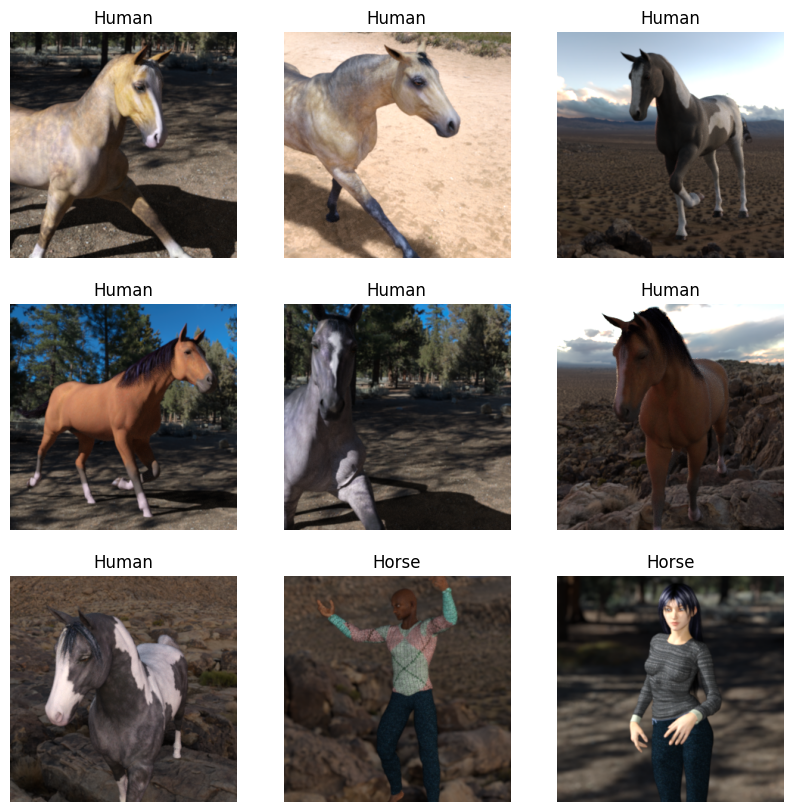

In [21]:
# c. Plot some images
def plot_images(dataset):
    plt.figure(figsize=(10,10))
    for i, (image, label) in enumerate(dataset.take(9)):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image.numpy())
        plt.title('Horse' if label == 1 else 'Human')
        plt.axis('off')

plot_images(train_data)

In [22]:
# d. Image augmentation – contrast, flipping, and rotation
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)
    image = tf.image.rot90(image, k=np.random.randint(4))  # Random rotation
    return image

augmented_train_data = train_data.map(lambda x, y: (augment_image(x), y))


In [23]:
# e. After augmentation, show the number of testing and training images
augmented_train_size = tf.data.experimental.cardinality(augmented_train_data)
print(f'Augmented training images: {augmented_train_size}')
print(f'Testing images: {test_size}')

Augmented training images: 1027
Testing images: 256


In [24]:
# f. Normalizing the training data
def normalize_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalization to [0, 1]
    return image, label

def resize_image(image, label):
    image = tf.image.resize(image, (150, 150))  # Resize image to 150x150
    return image, label

# Apply resizing to the datasets before batching
train_data = train_data.map(resize_image).map(normalize_image)
augmented_train_data = augmented_train_data.map(resize_image).map(normalize_image)
test_data = test_data.map(resize_image).map(normalize_image)

# Now batch the dataset after resizing
train_data = train_data.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
augmented_train_data = augmented_train_data.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# g. Build a convolutional neural network (CNN) to train images
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        # layers.Dropout(0.5), Dropout with 50% rate (to avoid overfitting)
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn()

# Train the CNN model with the original training data
history_cnn = cnn_model.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5
33/33 [==============================] - 20s 571ms/step - loss: 0.3632 - accuracy: 0.8257 - val_loss: 0.9935 - val_accuracy: 0.8516
Epoch 2/5
33/33 [==============================] - 18s 535ms/step - loss: 0.0698 - accuracy: 0.9737 - val_loss: 2.2585 - val_accuracy: 0.8242
Epoch 3/5
33/33 [==============================] - 18s 534ms/step - loss: 0.0467 - accuracy: 0.9786 - val_loss: 2.4477 - val_accuracy: 0.7969
Epoch 4/5
33/33 [==============================] - 17s 528ms/step - loss: 0.0378 - accuracy: 0.9864 - val_loss: 2.7160 - val_accuracy: 0.8086
Epoch 5/5
33/33 [==============================] - 19s 573ms/step - loss: 0.0116 - accuracy: 0.9951 - val_loss: 2.6603 - val_accuracy: 0.8125


In [29]:
# h. Show the training and testing accuracy for CNN
print(f"Training Accuracy (CNN): {history_cnn.history['accuracy'][-1]}")
print(f"Testing Accuracy (CNN): {history_cnn.history['val_accuracy'][-1]}")


Training Accuracy (CNN): 0.9951314330101013
Testing Accuracy (CNN): 0.8125


In [30]:
# Train the CNN model with the augmented training data
cnn_model_aug = build_cnn()
history_cnn_aug = cnn_model_aug.fit(augmented_train_data, epochs=5, validation_data=test_data)

Epoch 1/5
33/33 [==============================] - 24s 657ms/step - loss: 0.7378 - accuracy: 0.5112 - val_loss: 0.7176 - val_accuracy: 0.5000
Epoch 2/5
33/33 [==============================] - 21s 620ms/step - loss: 0.6679 - accuracy: 0.5881 - val_loss: 0.5579 - val_accuracy: 0.7539
Epoch 3/5
33/33 [==============================] - 20s 604ms/step - loss: 0.5234 - accuracy: 0.7507 - val_loss: 5.2356 - val_accuracy: 0.5781
Epoch 4/5
33/33 [==============================] - 20s 600ms/step - loss: 0.3667 - accuracy: 0.8481 - val_loss: 6.5674 - val_accuracy: 0.6562
Epoch 5/5
33/33 [==============================] - 20s 608ms/step - loss: 0.2719 - accuracy: 0.8948 - val_loss: 5.3614 - val_accuracy: 0.7148


In [31]:
# Show the training and testing accuracy for CNN with augmented data
print(f"Training Accuracy (CNN Augmented): {history_cnn_aug.history['accuracy'][-1]}")
print(f"Testing Accuracy (CNN Augmented): {history_cnn_aug.history['val_accuracy'][-1]}")

Training Accuracy (CNN Augmented): 0.894839346408844
Testing Accuracy (CNN Augmented): 0.71484375
